                            Simplilearn Youtube video part 3
Keras Tutorial For Beginners | Keras For Deep Learning | Deep Learning Tutorial | Simplilearn

https://www.youtube.com/watch?v=pWp3PhYI-OU&t=2600s

In [1]:
# Mask Detector program. Import the necessary packages. Solved the imutils-cv2 problem in the 2nd video by installing 
# opencv-python.

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from imutils import paths
from imutils.video import VideoStream

import matplotlib.pyplot as plt
import numpy as np
import imutils
import time
import cv2
import os

In [2]:
# initialize the learning rate, number of epochs to train for, and batch size

INIT_LR = 1e-4
num_epochs = 10  # was 2 for initial coding purposes
BS = 32

In [3]:
datadir = "facemask"
labels =[]
data = []
img_size = 224

for category in os.listdir(datadir):
    path = os.path.join(datadir, category)

    for img in os.listdir(path):
        try:
            img_path = os.path.join(path, img)
            image = load_img(img_path, target_size=(img_size, img_size))
            image = img_to_array(image)
            
            # image = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
            # image = img_to_array(cv2.resize(image, (img_size, img_size)))
                                               
            image = preprocess_input(image)
            
            data.append(image)
            labels.append(category)
        except Exception as e:
            pass

print(labels[:10])

['without_mask', 'without_mask', 'without_mask', 'without_mask', 'without_mask', 'without_mask', 'without_mask', 'without_mask', 'without_mask', 'without_mask']


In [4]:
# perform one-hot encoding on the labels

lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)

In [5]:
labels[-10:]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [6]:
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=42)

In [7]:
# construct the training image generator for data augmentation

aug = ImageDataGenerator(rotation_range=20,
                         zoom_range=0.15,
                         width_shift_range=0.20,
                         height_shift_range=0.20,
                         shear_range=0.15,
                         horizontal_flip=True,
                         fill_mode="nearest")


In [8]:
# Load the MobileNetV2 network, ensuring the head FC layer sets are left off

baseModel = MobileNetV2(weights="imagenet", 
                        include_top=False,
                        input_tensor=Input(shape=(img_size, img_size, 3)))

C:\Users\Anthony\anaconda3\envs\py36_02\lib\site-packages\keras_applications\mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


In [9]:
# construct the head of the model that will be placed on top of the base model

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7,7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [10]:
# place the head FC model on top of the base model (this will become the actual model we will train)

model = Model(inputs=baseModel.input, outputs=headModel)

In [11]:
# loop over all layers in the base model and freeze them so they will *not* be updated during the first 
# training process

for layer in baseModel.layers:
    layer.trainable = False

In [12]:
# compile our model

print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR/num_epochs)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

[INFO] compiling model...


In [13]:
# train the head of the network

print("[INFO] training head...")
H = model.fit(aug.flow(trainX, trainY, batch_size=BS),
              steps_per_epoch=len(trainX) // BS,
              validation_data=(testX,testY),
              validation_steps=len(testX) // BS,
              epochs=num_epochs)

[INFO] training head...
  ...
    to  
  ['...']
Train for 37 steps, validate on 302 samples
Epoch 1/10
37/37 [==============================] - 154s 4s/step - loss: 0.6353 - accuracy: 0.6590 - val_loss: 0.3812 - val_accuracy: 0.8299
Epoch 2/10
37/37 [==============================] - 161s 4s/step - loss: 0.3734 - accuracy: 0.8397 - val_loss: 0.2298 - val_accuracy: 0.9167
Epoch 3/10
37/37 [==============================] - 191s 5s/step - loss: 0.3010 - accuracy: 0.8687 - val_loss: 0.1669 - val_accuracy: 0.9514
Epoch 4/10
37/37 [==============================] - 197s 5s/step - loss: 0.2499 - accuracy: 0.8977 - val_loss: 0.1375 - val_accuracy: 0.9618
Epoch 5/10
37/37 [==============================] - 201s 5s/step - loss: 0.2093 - accuracy: 0.9241 - val_loss: 0.1170 - val_accuracy: 0.9688
Epoch 6/10
37/37 [==============================] - 200s 5s/step - loss: 0.1800 - accuracy: 0.9267 - val_loss: 0.0906 - val_accuracy: 0.9722
Epoch 7/10
37/37 [==============================] - 200s 5s/s

In [14]:
# make predictions on the testing set

print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

[INFO] evaluating network...


In [15]:
# for each image in the testing set, we need to find the index of the label with corresponding largest
# predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs, target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       0.96      0.99      0.97       151
without_mask       0.99      0.95      0.97       151

    accuracy                           0.97       302
   macro avg       0.97      0.97      0.97       302
weighted avg       0.97      0.97      0.97       302



In [16]:
# serialize the model to disk. (commented out cause I don't wanna save so many things)

print("[INFO] saving mask detector model...")
model.save("mask_detector.model", save_format="h5")

[INFO] saving mask detector model...


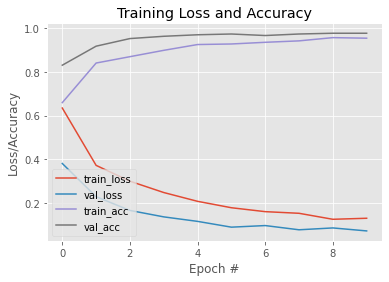

In [17]:
# plot the training loss and accuracy

N = num_epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")

plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")   # commented out cause I don't wanna save

# Last 11 minutes of the tutorial: OpenCV

Set up the webcam and run the above model

In [26]:
def detect_and_predict_mask(frame, faceNet, maskNet):

    # grab the dimensions of the frame and then construct a blob from it
    (h, w) = frame.shape[:2]
    blob = cv2.dnn.blobFromImage(frame, 1.0, (h, w), (104.0, 177.0, 123.0))
    
    # pass the blob through the network and obtain the face detections
    faceNet.setInput(blob)
    detections = faceNet.forward()
    print(detections.shape)
    
    # initialize our list of faces, their corresponding locations, and the list 
    # of predictions from our face mask network
    faces = []
    locs = []
    preds = []
    
    # loop over the detections
    for i in range(0, detections.shape[2]):
        # extract the confidence (i.e. probability) associated with the detection
        confidence = detections[0, 0, i, 2]
        
        # filter out weak detections by ensuring the confidence is greater than the
        # minimum confidence
        if confidence > 0.5:
            # compute the (x, y)-coordinates of the bounding box for the object
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")
            
            # ensure the bounding boxes fall within the dimensions of the frame
            (startX, startY) = (max(0, startX), max(0, startY))
            (endX, endY) = (min(w - 1, endX), min(h - 1, endY))
            
            # extract the face ROI, convert it from BGR to RGB channel ordering,
            # resize it to 224x224, and preprocess itface = frame[]
            face = frame[startY:endY, startX:endX]
            face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
            face = cv2.resize(face, (224, 224))
            face = img_to_array(face)
            face = preprocess_input(face)
            
            # add the face and bounding boxes to their respective lists
            faces.append(face)
            locs.append((startX, startY, endX, endY))
            
    # only make predictions if at least one face was detected
    if len(faces) > 0:
        # for faster inference we'll make batch predictions on ALL faces at the same
        # time rather than one-by-one predictions in the above 'for' loop
        faces = np.array(faces, dtype="float32")
        preds = maskNet.predict(faces, batch_size=32)
        
    # return a 2-tuple of the face locations and their corresponding locations
    return (locs, preds)

In [27]:
# load our serialized face detector model from disk. Found first 2 files on githhub using google search. 
# downloaded from https://github.com/opencv/opencv/blob/master/samples/dnn/face_detector/deploy.prototxt 
# downloaded from https://github.com/gopinath-balu/computer_vision/blob/master/CAFFE_DNN/res10_300x300_ssd_iter_140000.caffemodel

prototxtPath = r"face_detector\deploy.prototxt"
weightsPath = r"face_detector\res10_300x300_ssd_iter_140000.caffemodel"
faceNet = cv2.dnn.readNet(prototxtPath, weightsPath)

# load the face mask detector model from disk
maskNet = load_model("mask_detector.model")


In [29]:
# initialize the video stream
print("[INFO] starting video stream...")
# vs = VideoStream(src=0).start()  #loop over the frames from the video stream
vs = cv2.VideoCapture(0)

while True:
    # grab the frame from the threaded video stream and resize it to have a 
    # maximum width of 400 pixels
    ret, frame = vs.read()
    # frame = vs.read()
    frame = imutils.resize(frame, width=400)
    
    # detect faces in the frame and determine if they are wearing a mask or not
    (locs, preds) = detect_and_predict_mask(frame, faceNet, maskNet)
    

    # loop over the detected face locations and their corresponding locations
    for (box, pred) in zip(locs, preds):
        # unpack the bounding box and predictions
        (startX, startY, endX, endY) = box
        (mask, withoutMask) = pred
        
        # determine the class label and color we'll use to draw the bounding box and text
        label = "Mask" if mask > withoutMask else "No Mask"
        color = (0, 255, 0) if label == "Mask" else (0, 0, 255)
        
        # include the probability in the label
        label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)
        
        # display the label and bounding box rectangle on the output frame
        cv2.putText(frame, label, (startX, startY - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
        cv2.rectangle(frame, (startX, startY), (endX, endY), color, 2)
    
    # show the output frame
    cv2.imshow("Frame", frame)
        
    # if the 'q' key was pressed, break from the loop
    if cv2.waitKey(1) & 0xFF == ord("q"):
        break
        

# clean up
vs.release()
cv2.destroyAllWindows()

[INFO] starting video stream...
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 2

In [25]:
vs.release()
cv2.destroyAllWindows()